In [1]:
from netCDF4 import Dataset
import rasterio
import os
from datetime import datetime
import numpy as np

In [2]:
# local libraries
from coupling_PCR_FM.model_functions_v2 import PCR_model, CMF_model, DFM_model
from coupling_PCR_FM.utils import config_to_dict, determineSteps
%config Application.log_level="INFO"

In [3]:
# IMPORT MODEL SETTINGS FROM INI-FILE
argv1 = r'default_rename.set'
argv2 = r'paths.env'

# parse set/ini-file with central/general settings for coupling framework
config = config_to_dict(argv1)
# parse env-file for user-specific paths and environmental variables
envs = config_to_dict(argv2)
# combine
config.update(envs)
options = config
# parse dates
start_date = datetime.strptime(options['numerical_settings']['startTime'], '%Y-%m-%d')
end_date = datetime.strptime(options['numerical_settings']['endTime'], '%Y-%m-%d')
print start_date
print end_date
timeSteps = determineSteps(start_date, end_date)
print timeSteps

2000-01-01 00:00:00
2000-12-31 00:00:00
365


In [4]:
# setup output dir
cwd = os.getcwd() # note: this get changed by pcr initialization later on
out_dir = options['PCRpaths']['outputDirectoryPCR']
out_dir = out_dir + 'PCR2CMF/'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
print(out_dir)
print(cwd)

/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF/
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim


## create PCR model BMI object

Note that we use a two step initializiation. in the first step the bmi object is initialized and the model config file is read into memory. This config file can then be changed offline before the model is initialized. This allows for change model input files and setting based on the model coupling.

In [5]:
PCR_configfile = os.path.join(cwd, options['hydrologic_model']['config_dir'], options['hydrologic_model']['config_file'])
PCR_in_dir = options['PCRpaths']['inputDirectoryPCR']
PCR_out_dir = os.path.join(out_dir, 'PCR')

PCR_bmi = PCR_model(PCR_configfile, PCR_in_dir, PCR_out_dir,
                            start_date, end_date)


The illustrate the two-step initialization, the model config file is shown

In [6]:
PCR_bmi.model_config

OrderedDict([(u'globalOptions',
              OrderedDict([('inputDir',
                            u'/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/PCR_Elbe/input30min'),
                           ('cloneMap', u'clone_elbe_30min.map'),
                           ('landmask', u'landmask_elbe_30min.map'),
                           ('outputDir',
                            u'/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF/PCR'),
                           ('institution',
                            u'Department of Physical Geography, Utrecht University'),
                           ('title', u'PCR-GLOBWB output'),
                           ('description',
                            u'test version by Edwin H. Sutanudjaja; adapted by J. Hoch'),
                           ('startTime', '2000-01-01'),
                           ('endTime', '2000-12-31'),
                           ('maxSpinUpsInYears', u'1'),
                           ('minConvForTotlSto', u'0.5'),
  

## create CMF model BMi object

In [7]:
CMF_engine = os.path.join(cwd, options['CMF_engine']['CMF_path'])
CMF_model_dir = os.path.join(cwd, options['routing_model']['model_dir'])
CMF_config_fn = os.path.join(CMF_model_dir, options['routing_model']['model_file'])
CMF_out_dir = os.path.join(out_dir, 'CMF')
     
CMF_bmi = CMF_model(CMF_engine, CMF_config_fn, CMF_model_dir, CMF_out_dir,
                         start_date, end_date)

2018-03-06 15:23:57,869 - INFO - Loading library from path /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/cama-flood_bmi/src/libcama.so


## couple grids based on CMF inpmat file

In [8]:
# couple
PCR_bmi.couple_grid_to_grid(CMF_bmi)

2018-03-06 15:23:58,010 - INFO - Getting PCR model grid parameters.
2018-03-06 15:23:58,013 - INFO - Getting CMF model grid parameters.
2018-03-06 15:23:58,015 - INFO - Coupling PCR grid to CMF grid.
2018-03-06 15:23:58,016 - INFO - ./generate_inpmat 0.5 7.0 17.0 55.0 48.0 NtoS
2018-03-06 15:23:58,098 - INFO - Editing PCR ldd grid to deactivate routing in coupled cells.


## initialize models

In [9]:
# initialize model at CMF_out_dir after inpmat has been set in the grid_to_grid coupling function.
CMF_bmi.initialize()
# initialize model 
PCR_bmi.initialize()

2018-03-06 15:23:58,106 - INFO - removing tmp file diminfo_tmp.txt from model data dir
2018-03-06 15:23:58,111 - INFO - removing tmp file inpmat-tmp.txt from model data dir
2018-03-06 15:23:58,112 - INFO - removing tmp file inpmat-tmp.bin from model data dir
2018-03-06 15:23:58,115 - INFO - Ini file for CMF written to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF/CMF/input_flood.nam
2018-03-06 15:23:58,116 - INFO - Loading model /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF/CMF/input_flood.nam in directory /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF/CMF
2018-03-06 15:23:58,123 - INFO - CMF initialized
2018-03-06 15:23:58,128 - INFO - Ini file for PCR written to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF/PCR/setup_PCR_30min_Elbe.ini
2018-03-06 15:23:58,136 - INFO - Model run started at 2018-03-06 15:23:58.129402
2018-03-06 15:23:58,136 pcrglobwb_bmi_v203.configuration INFO Model run started at 2018-03-06 15:23:58.129402
2018-03-06 15:

## run coupled PCR - CMF model

In [10]:
# run coupled model for 20 timesteps
def update_states():
    "coupling runoff between CMFan PCR model"
    runoff = PCR_bmi.get_var('landSurfaceRunoff')
    runoff = np.where(np.isnan(runoff), 0, runoff)
    CMF_bmi.set_var("roffin", runoff)
        
tStart = datetime.now()
# for i in range(timeSteps):
for i in range(20):
    PCR_bmi.update()
    update_states()
    CMF_bmi.update()   
tEnd = datetime.now()

2018-03-06 15:24:10,626 - INFO - reading forcings for time 2000-01-01
2018-03-06 15:24:10,626 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-01
2018-03-06 15:24:10,844 - INFO - updating model to time 2000-01-01
2018-03-06 15:24:10,844 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-01
2018-03-06 15:24:12,828 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
2018-03-06 15:24:12,828 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
2018-03-06 15:24:13,061 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-02 00:00:00, timestep 86400.0
2018-03-06 15:24:13,061 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-02 00:00:00, timestep 86400.0
2018-03-06 15:24:13,063 - INFO - reading forcings for time 2000-01-02
2018-03-06 15:24:13,063 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-02
2

2018-03-06 15:24:27,993 - INFO - reading forcings for time 2000-01-11
2018-03-06 15:24:27,993 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-11
2018-03-06 15:24:28,448 - INFO - updating model to time 2000-01-11
2018-03-06 15:24:28,448 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-11
2018-03-06 15:24:29,519 - INFO - PCR -> start_time: 2000-01-01, current_time 2000-01-11, timestep 11
2018-03-06 15:24:29,519 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-11, timestep 11
2018-03-06 15:24:29,621 - INFO - CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-12 00:00:00, timestep 86400.0
2018-03-06 15:24:29,621 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-12 00:00:00, timestep 86400.0
2018-03-06 15:24:29,626 - INFO - reading forcings for time 2000-01-12
2018-03-06 15:24:29,626 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-12

2018-03-06 15:24:44,484 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-21 00:00:00, timestep 86400.0


In [11]:
print 'start time coupling: ', tStart
print 'end time coupling: ', tEnd
print 'average time per update PCR->CMF->DFM: ', abs((tEnd - tStart)) / timeSteps

start time coupling:  2018-03-06 15:24:10.626315
end time coupling:  2018-03-06 15:24:44.495728
average time per update PCR->CMF->DFM:  0:00:00.092792


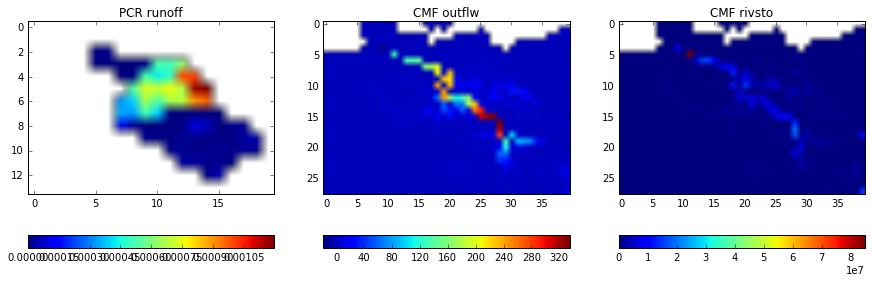

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

# PCR_bmi.update()
# routingModel.update_states()
# routingModel.update() 

runoff = PCR_bmi.get_var('landSurfaceRunoff')
outflw = CMF_bmi.get_var('outflw')
outflw = np.ma.masked_greater(outflw, 1.e19)
rivsto = CMF_bmi.get_var('rivsto_out')
rivsto = np.ma.masked_greater(rivsto, 1.e19)

fig = plt.figure(figsize=(15, 5))
a=fig.add_subplot(1,3,1)
imgplot = plt.imshow(runoff)
a.set_title('PCR runoff')
plt.colorbar(orientation ='horizontal')
a=fig.add_subplot(1,3,2)
imgplot = plt.imshow(outflw)
a.set_title('CMF outflw')
plt.colorbar(orientation='horizontal')
a=fig.add_subplot(1,3,3)
imgplot = plt.imshow(rivsto)
a.set_title('CMF rivsto')
plt.colorbar(orientation='horizontal')

In [13]:
# finalize model
PCR_bmi.finalize()

# finalize model
CMF_bmi.finalize()

2018-03-06 15:24:45,720 - INFO - cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim
2018-03-06 15:24:45,720 bmi.wrapper INFO cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim
